# Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn
# Курсовой Проект Ершова Андрея Александровича

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cdist

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


%matplotlib inline

pd.options.display.max_columns = 100

In [465]:
#'c:\\Users\\andre\\source\\repos\\python\\DataScience\\project_task\\'
TRAIN_MODEL_PATH = './train.csv'
TEST_MODEL_PATH = './test.csv'


In [470]:
df = pd.read_csv(TRAIN_MODEL_PATH)

###### Описание датасета:

$Id$ : идентификационный номер квартиры
<br>
$DistrictId$ : идентификационный номер района
<br>
$Rooms$ : количество комнат
<br>
$Square$ : площадь
<br>
$LifeSquare$ : жилая площадь
<br>
$KitchenSquare$ : площадь кухни
<br>
$Floor$ : этаж
<br>
$HouseFloor$ : количество этажей в доме
<br>
$HouseYear$ : год постройки дома
<br>
$Ecology\_1, Ecology\_2, Ecology\_3$ : экологические показатели местности
<br>
$Social\_1, Social\_2, Social\_3$ : социальные показатели местности
<br>
$Healthcare\_1, Helthcare\_2$ : показатели местности, связанные с охраной здоровья
<br>
$Shops\_1, Shops\_2$ : показатели, связанные с наличием магазинов, торговых центров
<br>
$Price$ : цена квартиры

In [468]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Библиотечные функции

In [17]:
def getStatisticsByColumn(columnName, sortName='Count', asc=True):
    group = df.groupby(columnName)
    df_stat = pd.DataFrame(group.apply(lambda x: x[columnName].unique()[0]))
    df_stat.columns = [columnName]
    df_stat.loc[:,'Count'] = group.apply(lambda x: x[columnName].count())
    df_stat.reset_index(inplace=True, drop=True)
    return df_stat.sort_values(by=sortName, axis=0, ascending=asc)

In [18]:
def fillEmptyObservationsByMedian(columnName):
    mdn = df[columnName].median()
    df[columnName] = df[columnName].fillna(mdn)
    return 0

In [19]:
def transformCategorialToBinary(dFrame, columnName):
    matching = filter(lambda column: columnName in column, dFrame.columns)

    if len(list(matching)) > 0:
        dFrame = pd.concat([dFrame, pd.get_dummies(dFrame[columnName])], axis=1)
        dFrame.rename(columns={"A": columnName + "A", "B": columnName + "B"}, inplace=True)
        dFrame.drop(columnName, axis=1, inplace=True)
    return dFrame

In [94]:
def apply_elbow_method(d_frame):
    distortions = []
    K = range(2,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(d_frame)
        distortions.append(sum(np.min(cdist(d_frame, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / d_frame.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [21]:
def display_clusters_distribution(unique_labels, labels_counts):
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clгsters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

In [90]:
def reduce_dims_to_2D_space_with_PCA(d_frame):
    pca = PCA(n_components=2)
    components = pca.fit_transform(d_frame)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2'])
    
def reduce_dims_to_3D_space_with_PCA(d_frame):
    pca = PCA(n_components=3)
    components = pca.fit_transform(d_frame)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2', 'component_3'])

def reduce_dims_to_2D_space_with_TSNE(d_frame):
    tsne = TSNE(n_components=2, learning_rate=250, random_state=42)
    components = tsne.fit_transform(d_frame)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2'])
    
def reduce_dims_to_3D_space_with_TSNE(d_frame):
    tsne = TSNE(n_components=3, learning_rate=250, random_state=42)
    components = tsne.fit_transform(d_frame)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2', 'component_3']) 

In [120]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2_score(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mean_absolute_error(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mean_squared_error(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10)) 
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

Нормализация поля $DistrictId$

In [454]:
print(getStatisticsByColumn('DistrictId')[:10])

     DistrictId  Count
204         209      1
202         207      1
201         205      1
117         117      1
197         199      1
196         196      1
174         174      1
200         202      2
203         208      2
195         195      2


In [455]:
df.loc[df.DistrictId == 0, 'DistrictId'] = df.DistrictId.median()

Нормализация поля $Rooms$

In [456]:
print(getStatisticsByColumn('Rooms')[:10])

   Rooms   Count
6    6.0     1.0
8   19.0     1.0
7   10.0     2.0
0    0.0     8.0
5    5.0    18.0
4    4.0   150.0
3    3.0  2235.0
1    1.0  3705.0
2    2.0  3880.0


In [457]:
df.Rooms = df.Rooms.astype(int)

In [458]:
print('средний метраж для однушек:   ', df.loc[df['Rooms'] == 1].median()['Square'])
print('средний метраж для двушек:    ', df.loc[df['Rooms'] == 2].median()['Square'])
print('средний метраж для трёшек:    ', df.loc[df['Rooms'] == 3].median()['Square'])
print('средний метраж для четвёрок:  ', df.loc[df['Rooms'] == 4].median()['Square'])
print('средний метраж для пятёрок:   ', df.loc[df['Rooms'] == 5].median()['Square'])
print('средний метраж для шестёрок:  ', df.loc[df['Rooms'] == 6].median()['Square'])

средний метраж для однушек:    40.40658991236909
средний метраж для двушек:     55.84181213903055
средний метраж для трёшек:     77.41364294803941
средний метраж для четвёрок:   98.66805357992513
средний метраж для пятёрок:    116.08486083443316
средний метраж для шестёрок:   59.41433379627719


In [459]:
df.loc[df.Rooms == 6] 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2170,14003,99.0,6,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416


Корректировка количества комнат на основании средних значений метража

In [460]:
df.loc[df.Id == 12638, 'Rooms'] = 5
df.loc[df.Id == 7917, 'Rooms'] = 10
df.loc[df.Id == 7317, 'Rooms'] = 1
df.loc[df.Id == 770, 'Rooms'] = 1
df.loc[df.Id == 456, 'Rooms'] = 3
df.loc[df.Id == 3159, 'Rooms'] = 1
df.loc[df.Id == 9443, 'Rooms'] = 3
df.loc[df.Id == 8491, 'Rooms'] = 1
df.loc[df.Id == 5927, 'Rooms'] = 2
df.loc[df.Id == 14865, 'Rooms'] = 1
df.loc[df.Id == 7594, 'Rooms'] = 1
df.loc[df.Id == 14003, 'Rooms'] = 2

Нормализация поля $Square$

In [461]:
df.loc[(df.Square < 10)] 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88.0,2,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
1316,11526,27.0,1,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441
1608,10202,6.0,1,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
3280,10527,27.0,1,4.380726,40.805837,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383
3413,9487,5.0,1,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
4853,3224,27.0,0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
4900,4504,27.0,3,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034
6392,14786,1.0,1,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589
8030,13265,1.0,3,4.823679,79.767964,0.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261
8283,15744,34.0,1,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006


Невеверные значения, подлежащие удалению

In [462]:
df.drop(df[(df.Square < 10) & (df.Square < df.LifeSquare)].index, inplace=True)
df.loc[(df.Id.isnull() == True)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


Невеверные значения, подлежащие коррекции

In [231]:
df.loc[(df.Square < 10), 'Square'] = df.loc[(df.Square < 10), 'Square'] * 10
df.loc[(df.Square < 10), 'LifeSquare'] = df.loc[(df.Square < 10), 'LifeSquare'] * 10

Нормализация поля $LifeSquare$
<br>
<br>
Признак $LifeSquare$ имеeт высокую степень разряжения.
<br>
Заполняем отсутсвующие в этом столбце значения соотвествующими медианными значениями. 

In [232]:
fillEmptyObservationsByMedian('LifeSquare')

0

In [233]:
df.loc[(df.LifeSquare < 10)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
26,4378,27.0,3,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
95,4280,34.0,2,61.334968,4.091945,1.0,26,1.0,2014,0.069753,B,B,53,13670,4,NaN,1,11,B,286564.441972
134,12613,6.0,2,65.496674,5.589324,1.0,5,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,180727.643541
158,16779,27.0,3,51.991064,4.896202,1.0,22,25.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,174687.566186
160,3522,6.0,1,66.419841,3.987101,1.0,2,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,193361.229815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,13583,27.0,2,58.943039,3.319486,1.0,11,17.0,2017,0.011654,B,B,4,915,0,NaN,0,0,B,142789.948977
9813,2040,62.0,1,122.438148,5.751401,1.0,2,3.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,224900.897679
9828,13630,24.0,3,127.141143,4.811405,1.0,3,1.0,2017,0.111627,B,B,50,12238,8,1970.0,2,3,B,611250.912034
9888,6053,6.0,1,41.314775,5.005477,1.0,9,17.0,2016,0.243205,B,B,5,1564,0,540.0,0,0,B,159149.515475


Невеверные значения, подлежащие коррекции (при необходимости, повторить)

In [234]:
df.loc[(df.LifeSquare < 10), 'LifeSquare'] = df.loc[(df.LifeSquare < 10), 'LifeSquare'] * 10
df.loc[(df.LifeSquare < 10), 'LifeSquare'] = df.loc[(df.LifeSquare < 10), 'LifeSquare'] * 10

In [235]:
df.loc[df.LifeSquare > 5000, 'LifeSquare'] = df.LifeSquare.median()

Нормализация поля $KitchenSquare$

In [236]:
df.loc[(df.KitchenSquare == 0)] 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,4765,53.0,2,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
7,11993,74.0,2,80.312926,32.784434,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
23,6641,54.0,3,118.907612,32.784434,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
26,4378,27.0,3,106.958871,64.182211,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
39,9371,23.0,2,60.503248,32.784434,0.0,16,0.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,229778.057902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9948,8438,1.0,2,66.736039,32.784434,0.0,16,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,199237.847364
9953,5365,1.0,2,61.049491,32.784434,0.0,11,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,190085.168584
9960,9307,1.0,2,57.376642,32.784434,0.0,8,25.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,104450.496477
9965,6612,27.0,2,59.460685,32.784434,0.0,15,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,135784.320930


Невеверные значения, подлежащие коррекции

In [237]:
df.loc[(df.KitchenSquare == 0), 'KitchenSquare'] = df.KitchenSquare.median()
df.loc[(df.KitchenSquare > df.LifeSquare), 'KitchenSquare'] = df.KitchenSquare.median()

Нормализация поля $Floor$

In [238]:
df.loc[(df.Floor > 100)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


Нормализация поля $HouseFloor$

In [239]:
df.HouseFloor = df.HouseFloor.astype(int)

In [240]:
print(getStatisticsByColumn('HouseFloor', 'HouseFloor', False)[:10])

    HouseFloor  Count
43         117      1
42          99      2
41          48      2
40          47      1
39          45      1
38          44      1
37          40      7
36          39      2
35          38      1
34          37      4


In [241]:
df.loc[(df.HouseFloor > 50), 'HouseFloor'] = df.HouseFloor.median()

Нормализация поля $HouseYear$

In [242]:
print(getStatisticsByColumn('HouseYear')[:10])

    HouseYear  Count
0        1910      1
95       4968      1
22       1947      1
7        1928      1
96   20052011      1
3        1916      1
2        1914      1
1        1912      2
8        1929      2
11       1932      2


In [243]:
df.loc[(df.HouseYear == 20052011), 'HouseYear'] = 2005
df.loc[(df.HouseYear > 2020), 'HouseYear'] = df.HouseYear.median()

Нормализация поля $Ecology\_1$

In [244]:
print(getStatisticsByColumn('Ecology_1')[:10])

        Ecology_1  Count
21   1.433395e-02    1.0
18   1.252163e-02    1.0
121  3.940942e-01    2.0
15   1.131981e-02    3.0
120  3.867717e-01    6.0
23   1.458072e-02    7.0
105  2.466236e-01    9.0
1    1.800000e-09   10.0
49   5.181543e-02   11.0
9    4.949358e-03   11.0


Нормализация поля $Ecology\_2$
<br>
<br>
Преобразуем категориальный признак $Ecology\_2$ в несколько бинарных

In [245]:
df = transformCategorialToBinary(df, 'Ecology_2')
df.drop("Ecology_2B", axis=1, inplace=True)

In [246]:
print(getStatisticsByColumn('Ecology_2A')[:10])

   Ecology_2A  Count
1           1     97
0           0   9893


In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9990 entries, 0 to 9999
Data columns (total 20 columns):
Id               9990 non-null int64
DistrictId       9990 non-null float64
Rooms            9990 non-null int32
Square           9990 non-null float64
LifeSquare       9990 non-null float64
KitchenSquare    9990 non-null float64
Floor            9990 non-null int64
HouseFloor       9990 non-null float64
HouseYear        9990 non-null float64
Ecology_1        9990 non-null float64
Ecology_3        9990 non-null object
Social_1         9990 non-null int64
Social_2         9990 non-null int64
Social_3         9990 non-null int64
Healthcare_1     5199 non-null float64
Helthcare_2      9990 non-null int64
Shops_1          9990 non-null int64
Shops_2          9990 non-null object
Price            9990 non-null float64
Ecology_2A       9990 non-null uint8
dtypes: float64(9), int32(1), int64(7), object(2), uint8(1)
memory usage: 1.5+ MB


Нормализация поля $Ecology\_3$
<br>
<br>
Преобразуем категориальный признак $Ecology\_3$ в несколько бинарных

In [248]:
df = transformCategorialToBinary(df, 'Ecology_3')
df.drop("Ecology_3B", axis=1, inplace=True)

In [249]:
print(getStatisticsByColumn('Ecology_3A')[:10])

   Ecology_3A  Count
1           1    275
0           0   9715


Нормализация поля $Social\_1$

In [250]:
print(getStatisticsByColumn('Social_1', 'Social_1')[:10])

   Social_1  Count
0         0    201
1         1    652
2         2    688
3         3      9
4         4    141
5         5    527
6         6    377
7         7     15
8         8     62
9         9    211


Нормализация поля $Social\_2$

In [251]:
print(getStatisticsByColumn('Social_2', 'Social_2')[:10])

   Social_2  Count
0       168    190
1       186     11
2       264    585
3       290     11
4       388     56
5       469    142
6       475     55
7       507      1
8       528      1
9       568      3


Нормализация поля $Social\_3$

In [252]:
print(getStatisticsByColumn('Social_3', 'Social_3')[:10])

   Social_3  Count
0         0   2992
1         1   1861
2         2    634
3         3   1135
4         4    833
5         5    391
6         6    422
7         7    184
8         8    170
9         9    192


Нормализация поля $Healthcare\_1$
<br>
<br>
Признак $Healthcare\_1$ имеeт высокую степень разряжения.
<br>
Заполняем отсутсвующие в этом столбце значения соотвествующими медианными значениями. 

In [253]:
fillEmptyObservationsByMedian('Healthcare_1')

0

In [254]:
print(getStatisticsByColumn('Healthcare_1', 'Healthcare_1')[:10])

   Healthcare_1  Count
0           0.0    1.0
1          30.0  348.0
2          32.0   12.0
3          35.0    2.0
4          46.0   49.0
5          75.0   16.0
6          80.0   35.0
7         100.0   25.0
8         125.0  103.0
9         145.0   50.0


In [255]:
df.Healthcare_1 = df.Healthcare_1.astype(int)

Нормализация поля $Healthcare\_2$

In [256]:
df.rename(columns={"Helthcare_2": "Healthcare_2"}, inplace=True)

In [257]:
print(getStatisticsByColumn('Healthcare_2')[:10])

   Healthcare_2  Count
6             6     99
4             4    287
5             5    388
2             2   1158
3             3   1668
1             1   2182
0             0   4208


Нормализация поля $Shops\_1$

In [258]:
print(getStatisticsByColumn('Shops_1')[:10])

    Shops_1  Count
14       19     49
13       16     83
12       15    176
10       10    215
15       23    245
8         8    253
7         7    293
9         9    315
11       11    400
6         6    487


Нормализация поля $Shops\_2$
<br>
Преобразуем категориальный признак $Shops\_2$ в несколько бинарных

In [259]:
df = transformCategorialToBinary(df, 'Shops_2')
df.drop("Shops_2B", axis=1, inplace=True)

In [260]:
print(getStatisticsByColumn('Shops_2A')[:10])

   Shops_2A  Count
1         1    825
0         0   9165


##### Сохранение и извлечение модели из файла (pickle формат) для более быстрой инициализации

In [472]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9990 entries, 0 to 9999
Data columns (total 20 columns):
Id               9990 non-null int64
DistrictId       9990 non-null float64
Rooms            9990 non-null int32
Square           9990 non-null float64
LifeSquare       9990 non-null float64
KitchenSquare    9990 non-null float64
Floor            9990 non-null int64
HouseFloor       9990 non-null float64
HouseYear        9990 non-null float64
Ecology_1        9990 non-null float64
Social_1         9990 non-null int64
Social_2         9990 non-null int64
Social_3         9990 non-null int64
Healthcare_1     9990 non-null int32
Healthcare_2     9990 non-null int64
Shops_1          9990 non-null int64
Price            9990 non-null float64
Ecology_2A       9990 non-null uint8
Ecology_3A       9990 non-null uint8
Shops_2A         9990 non-null uint8
dtypes: float64(8), int32(2), int64(7), uint8(3)
memory usage: 1.3 MB


In [261]:
df.to_pickle("./dummy.pkl")

In [3]:
df = pd.read_pickle("./dummy.pkl")

#### Анализ модели 

In [4]:
target_mean = round(df.Price.mean(), 2)
target_median = df.Price.median()
target_mode = df.Price.mode()[0]

target_mean, target_median, target_mode

(214055.18, 192255.01789602835, 59174.77802758122)

In [5]:
feature_names = df.columns.tolist()[1:]
feature_names.remove('Price')

##### Проверка на всех признаках

In [404]:
X = df[feature_names]
y = df[['Price']]

y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9990 entries, 0 to 9999
Data columns (total 1 columns):
Price    9990 non-null float64
dtypes: float64(1)
memory usage: 156.1 KB


In [405]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [406]:
rfr = RandomForestRegressor(n_estimators=1000, max_depth=400, random_state=42)

In [268]:
%%time

rfr.fit(X_train, y_train.values[:, 0])

Wall time: 55.5 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=400,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [269]:
y_pred = rfr.predict(X_test)

In [270]:
check_test_rfr = pd.DataFrame({
    "y_test": y_test["Price"],
    "y_pred": y_pred.flatten()
})

check_test_rfr["error"] = check_test_rfr["y_pred"] - check_test_rfr["y_test"]

check_test_rfr.head()

,y_test,y_pred,error
4026,469497.535186,493178.437378,23680.902192
5417,182453.436044,193591.207333,11137.771289
488,118939.006034,120545.577158,1606.571124
39,229778.057902,147930.385496,-81847.672405
6801,329629.767283,378735.860435,49106.093152


In [271]:
mean_squared_error(check_test_rfr["y_test"], check_test_rfr["y_pred"])

2179256520.81118

In [272]:
mean_absolute_error(check_test_rfr["y_test"], check_test_rfr["y_pred"])

27886.73152386447

In [273]:
r2_score(check_test_rfr["y_test"], check_test_rfr["y_pred"]) 

0.7533499457303371

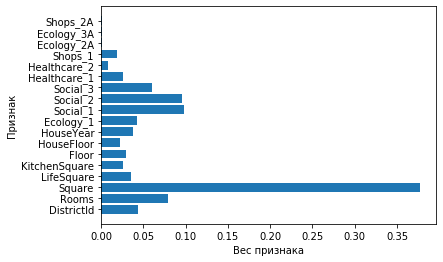

In [274]:
plt.barh(feature_names, rfr.feature_importances_.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

In [473]:
feature_names_for_stand = [
    feature
    for feature, weight in zip(feature_names, rfr.feature_importances_.flatten())
    if np.abs(weight) > 0.01
]

print(feature_names_for_stand)

['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Healthcare_2']


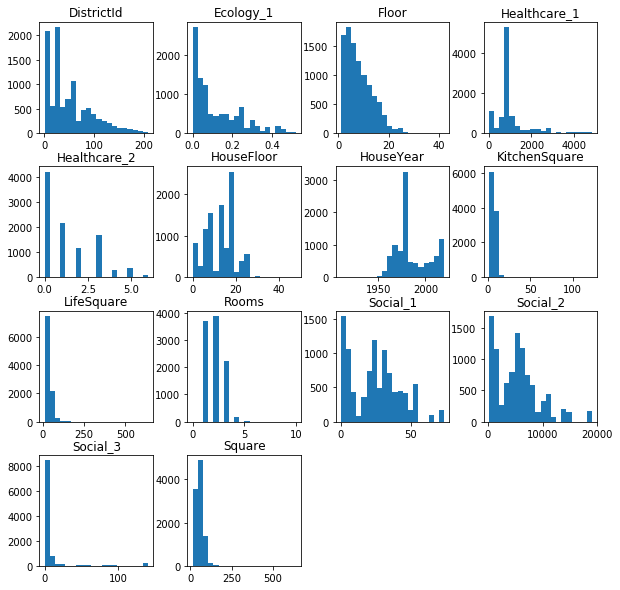

In [474]:
df_num_features = df[feature_names_for_stand]

df_num_features.hist(figsize=(10,10), bins=20, grid=False);

#### Подготовка и обучение модели

In [475]:
X = df[feature_names_for_stand]
y = df[['Price']]

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9990 entries, 0 to 9999
Data columns (total 14 columns):
DistrictId       9990 non-null float64
Rooms            9990 non-null int32
Square           9990 non-null float64
LifeSquare       9990 non-null float64
KitchenSquare    9990 non-null float64
Floor            9990 non-null int64
HouseFloor       9990 non-null float64
HouseYear        9990 non-null float64
Ecology_1        9990 non-null float64
Social_1         9990 non-null int64
Social_2         9990 non-null int64
Social_3         9990 non-null int64
Healthcare_1     9990 non-null int32
Healthcare_2     9990 non-null int64
dtypes: float64(7), int32(2), int64(5)
memory usage: 1.1 MB


In [476]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [477]:
rfr = RandomForestRegressor()

Попробуем натянуть сетку

In [280]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100],
    'max_features': [1, 2],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 4],
    'n_estimators': [1000]
}

grid_search = GridSearchCV(estimator = rfr, 
                           param_grid = param_grid, 
                           cv = 3
                          )

In [281]:
from sklearn import preprocessing
from sklearn import utils

In [282]:
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)

In [283]:
%%time

grid_search.fit(X_train, y_train_encoded)

Wall time: 5min 50s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap': [True], 'max_depth

In [284]:
print(grid_search.best_params_)

{'bootstrap': True, 'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1000}


In [412]:
rfr = RandomForestRegressor(
    bootstrap=True, 
    max_depth=100, 
    max_features=3, 
    min_samples_leaf=1,
    min_samples_split=4,
    n_estimators=1000, 
    random_state=42)

rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

In [413]:
check_test_rfr = pd.DataFrame({
    "y_test": y_test["Price"],
    "y_pred": y_pred.flatten()
})

check_test_rfr["error"] = check_test_rfr["y_pred"] - check_test_rfr["y_test"]

check_test_rfr.head()

,y_test,y_pred,error
4026,469497.535186,470265.223179,767.687992
5417,182453.436044,193466.025513,11012.589469
488,118939.006034,122652.192258,3713.186224
39,229778.057902,139900.682514,-89877.375387
6801,329629.767283,374695.503352,45065.736070


In [414]:
r2_score(check_test_rfr["y_test"], check_test_rfr["y_pred"]) 

0.7554233040231675

#### Процесс кластеризации

In [95]:
df.reset_index()

df_features = df.copy()
df_features.drop({'Price'}, axis=1, inplace=True)

df_price = df.copy()
df_price = df_price[['Price']]

df_features.loc[(df_features.Id.isnull() == True)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Ecology_2A,Ecology_3A,Shops_2A


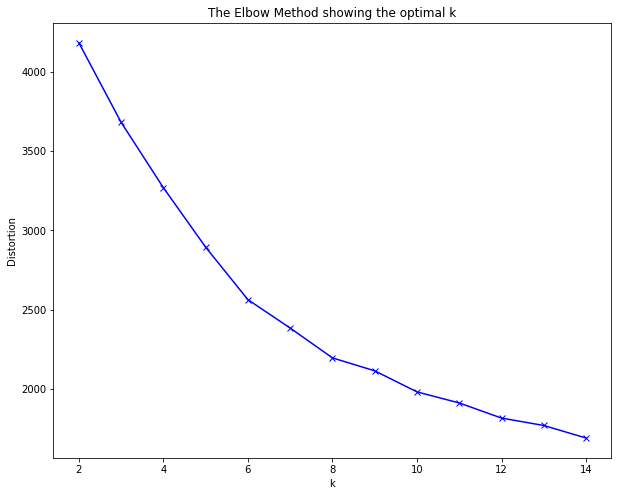

In [96]:
apply_elbow_method(df_features)

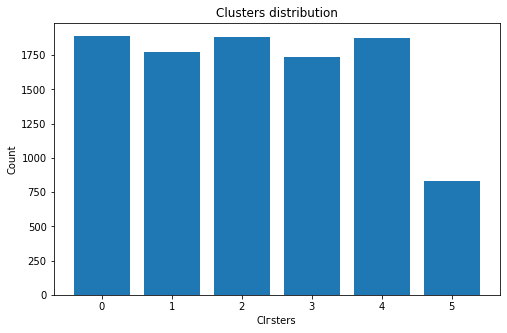

In [97]:
kmeans = KMeans(n_clusters=6, max_iter=100, random_state=42)

labels_train_6 = kmeans.fit_predict(df_features)
labels_train_6 = pd.Series(labels_train_6, name='clusters_6')

unique, counts = np.unique(labels_train_6, return_counts=True)
display_clusters_distribution(unique, counts)

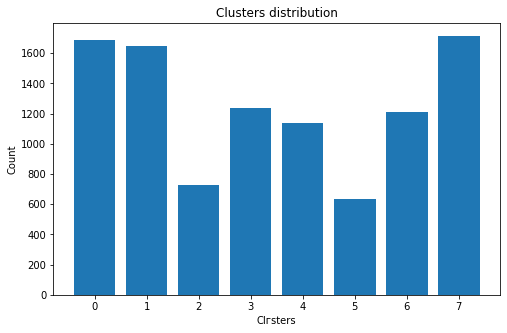

In [98]:
kmeans = KMeans(n_clusters=8, max_iter=100, random_state=42)

labels_train_8 = kmeans.fit_predict(df_features)
labels_train_8 = pd.Series(labels_train_8, name='clusters_8')

unique, counts = np.unique(labels_train_8, return_counts=True)
display_clusters_distribution(unique, counts)

In [101]:
components_3d = reduce_dims_to_3D_space_with_PCA(df_features)

In [103]:
clusters_6_dummies = pd.get_dummies(labels_train_6, drop_first=True, prefix='clusters_6')
clusters_8_dummies = pd.get_dummies(labels_train_8, drop_first=True, prefix='clusters_8')

df_ext = pd.concat([df_features, components_3d, clusters_6_dummies, clusters_8_dummies, df_price], axis=1)

pd.options.display.max_columns=200

In [161]:
df_ext.loc[(df_ext.component_1.isnull() == True)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Ecology_2A,Ecology_3A,Shops_2A,component_1,component_2,component_3,clusters_6_1,clusters_6_2,clusters_6_3,clusters_6_4,clusters_6_5,clusters_8_1,clusters_8_2,clusters_8_3,clusters_8_4,clusters_8_5,clusters_8_6,clusters_8_7,Price


In [159]:
df_ext.loc[(df_ext.Id.isnull() == True)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Ecology_2A,Ecology_3A,Shops_2A,component_1,component_2,component_3,clusters_6_1,clusters_6_2,clusters_6_3,clusters_6_4,clusters_6_5,clusters_8_1,clusters_8_2,clusters_8_3,clusters_8_4,clusters_8_5,clusters_8_6,clusters_8_7,Price


In [160]:
df_ext.dropna(subset=['Id'], inplace=True)
df_ext.dropna(subset=['component_1'], inplace=True)

In [164]:
df_ext.reset_index()

df_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9980 entries, 0 to 9989
Data columns (total 35 columns):
Id               9980 non-null float64
DistrictId       9980 non-null float64
Rooms            9980 non-null float64
Square           9980 non-null float64
LifeSquare       9980 non-null float64
KitchenSquare    9980 non-null float64
Floor            9980 non-null float64
HouseFloor       9980 non-null float64
HouseYear        9980 non-null float64
Ecology_1        9980 non-null float64
Social_1         9980 non-null float64
Social_2         9980 non-null float64
Social_3         9980 non-null float64
Healthcare_1     9980 non-null float64
Healthcare_2     9980 non-null float64
Shops_1          9980 non-null float64
Ecology_2A       9980 non-null float64
Ecology_3A       9980 non-null float64
Shops_2A         9980 non-null float64
component_1      9980 non-null float64
component_2      9980 non-null float64
component_3      9980 non-null float64
clusters_6_1     9980 non-null floa

In [165]:
components_3d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 3 columns):
component_1    9990 non-null float64
component_2    9990 non-null float64
component_3    9990 non-null float64
dtypes: float64(3)
memory usage: 234.3 KB


In [166]:
clusters_8_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 7 columns):
clusters_8_1    9990 non-null uint8
clusters_8_2    9990 non-null uint8
clusters_8_3    9990 non-null uint8
clusters_8_4    9990 non-null uint8
clusters_8_5    9990 non-null uint8
clusters_8_6    9990 non-null uint8
clusters_8_7    9990 non-null uint8
dtypes: uint8(7)
memory usage: 68.4 KB


In [106]:
clusters_6_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 5 columns):
clusters_6_1    9990 non-null uint8
clusters_6_2    9990 non-null uint8
clusters_6_3    9990 non-null uint8
clusters_6_4    9990 non-null uint8
clusters_6_5    9990 non-null uint8
dtypes: uint8(5)
memory usage: 48.9 KB


In [108]:
df_ext.to_pickle("./test_ext.pkl")

In [109]:
df_ext = pd.read_pickle("./test_ext.pkl")

In [110]:
df_ext.loc[(df_ext.Id.isnull())]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Ecology_2A,Ecology_3A,Shops_2A,component_1,component_2,component_3,clusters_6_1,clusters_6_2,clusters_6_3,clusters_6_4,clusters_6_5,clusters_8_1,clusters_8_2,clusters_8_3,clusters_8_4,clusters_8_5,clusters_8_6,clusters_8_7,Price


In [147]:
X = df_ext.iloc[:, :-1]
y = df_ext[['Price']]

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [149]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9980 entries, 0 to 9989
Data columns (total 34 columns):
Id               9980 non-null float64
DistrictId       9980 non-null float64
Rooms            9980 non-null float64
Square           9980 non-null float64
LifeSquare       9980 non-null float64
KitchenSquare    9980 non-null float64
Floor            9980 non-null float64
HouseFloor       9980 non-null float64
HouseYear        9980 non-null float64
Ecology_1        9980 non-null float64
Social_1         9980 non-null float64
Social_2         9980 non-null float64
Social_3         9980 non-null float64
Healthcare_1     9980 non-null float64
Healthcare_2     9980 non-null float64
Shops_1          9980 non-null float64
Ecology_2A       9980 non-null float64
Ecology_3A       9980 non-null float64
Shops_2A         9980 non-null float64
component_1      9980 non-null float64
component_2      9980 non-null float64
component_3      9980 non-null float64
clusters_6_1     9980 non-null floa

In [150]:
rfr = RandomForestRegressor()

Попробуем натянуть сетку

In [151]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100],
    'max_features': [1, 2],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 4],
    'n_estimators': [1000]
}

grid_search = GridSearchCV(estimator = rfr, 
                           param_grid = param_grid, 
                           cv = 3
                          )

In [152]:
from sklearn import preprocessing
from sklearn import utils

In [153]:
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)

In [128]:
%%time

grid_search.fit(X_train, y_train_encoded)

Wall time: 5min 26s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap': [True], 'max_depth

In [129]:
print(grid_search.best_params_)

{'bootstrap': True, 'max_depth': 100, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


In [154]:
rfr = RandomForestRegressor(
    bootstrap=True, 
    max_depth=100, 
    max_features=3, 
    min_samples_leaf=1,
    min_samples_split=4,
    n_estimators=1000, 
    random_state=42)

rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

In [155]:
check_test_rfr = pd.DataFrame({
    "y_test": y_test["Price"],
    "y_pred": y_pred.flatten()
})

check_test_rfr["error"] = check_test_rfr["y_pred"] - check_test_rfr["y_test"]

check_test_rfr.head()

,y_test,y_pred,error
1254,328017.739044,293950.095482,-34067.643563
8231,108952.090037,135356.196394,26404.106358
1660,92855.410323,84767.982913,-8087.427410
7739,240411.027528,222944.737489,-17466.290039
1442,139281.271068,149746.227817,10464.956749


In [156]:
r2_score(check_test_rfr["y_test"], check_test_rfr["y_pred"]) 

0.7216857232617859

In [114]:
final_model = GradientBoostingRegressor(n_estimators=400, max_depth=7, random_state=21)
final_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='auto',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.992
MAE:	6188.98
MSE:	70584688.42


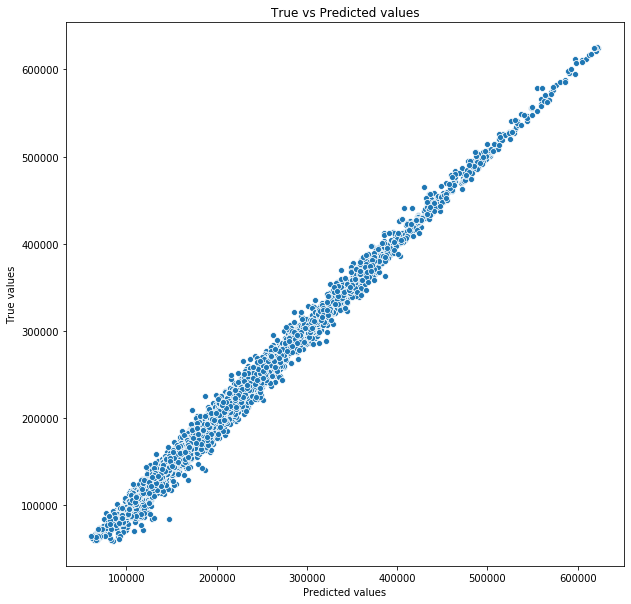

In [121]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.738
MAE:	28864.411
MSE:	2305767157.872


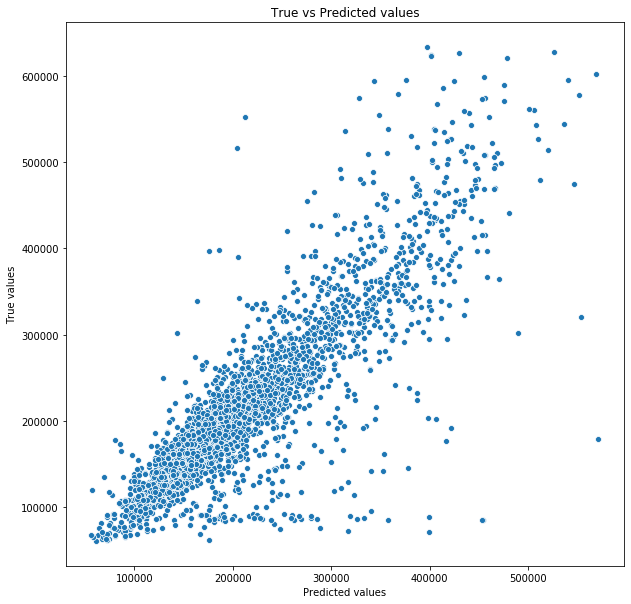

In [122]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [16]:
X_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price,Ecology_2A,Ecology_3A,component_1,component_2,component_3,clusters_5_1,clusters_5_2,clusters_5_3,clusters_5_4
count,6693.000000,6693.00000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,6693.000000,4702.000000,4702.000000,4702.000000,4702.000000
mean,8422.656357,50.68355,1.883460,56.139137,35.926626,6.213058,8.488720,12.616614,1984.699686,0.118725,24.676229,5334.218587,7.959958,1030.435978,1.333632,4.222919,213799.579115,0.011206,0.027491,190.359945,13.184331,45.805381,0.311144,0.052956,0.298171,0.239898
std,4853.716050,43.37881,0.813725,20.402617,17.743032,4.591082,5.211349,6.596452,18.497453,0.119631,17.457143,3976.953704,23.729804,746.989418,1.511067,4.812960,92530.467344,0.105270,0.163523,92065.507427,4870.752138,3884.503025,0.463011,0.223970,0.457504,0.427066
min,0.000000,1.00000,0.000000,13.784865,10.523868,1.000000,1.000000,0.000000,1912.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,-154200.819767,-8479.750242,-7410.505510,0.000000,0.000000,0.000000,0.000000
25%,4241.000000,21.00000,1.000000,41.818261,26.927493,4.000000,4.000000,9.000000,1973.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153997.912192,0.000000,0.000000,-60175.812225,-4219.797228,-3201.358835,0.000000,0.000000,0.000000,0.000000
50%,8427.000000,36.00000,2.000000,52.133425,32.784434,6.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192794.913406,0.000000,0.000000,-21746.336532,29.970778,-229.207799,0.000000,0.000000,0.000000,0.000000
75%,12653.000000,76.00000,2.000000,65.803613,41.241412,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1015.000000,2.000000,6.000000,249063.801948,0.000000,0.000000,36414.184529,4259.780766,1934.169838,1.000000,0.000000,1.000000,0.000000
max,16798.000000,209.00000,10.000000,641.065193,638.163193,123.000000,42.000000,48.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,625820.041178,1.000000,1.000000,413446.004099,8527.457686,15038.666221,1.000000,1.000000,1.000000,1.000000


In [ ]:
y_pred = rfr.predict(X_test)

In [223]:
y_pred = rfr.predict(X_test)

In [224]:
check_test_rfr = pd.DataFrame({
    "y_test": y_test["Price"],
    "y_pred": y_pred.flatten()
})

check_test_rfr["error"] = check_test_rfr["y_pred"] - check_test_rfr["y_test"]

check_test_rfr.head()

,y_test,y_pred,error
Id,,,
13326,469497.535186,492455.578930,22958.043744
6733,182453.436044,194637.265551,12183.829507
5104,118939.006034,125077.502337,6138.496303
9371,229778.057902,144995.240209,-84782.817692
71,329629.767283,379978.137785,50348.370503


In [225]:
mean_squared_error(check_test_rfr["y_test"], check_test_rfr["y_pred"])

2197064089.6599703

In [226]:
mean_absolute_error(check_test_rfr["y_test"], check_test_rfr["y_pred"])

28149.978709448853

In [227]:
r2_score(check_test_rfr["y_test"], check_test_rfr["y_pred"]) 

0.7513344703693502

In [22]:
colName = 'clusters_5_3'
group = X_train.groupby(colName)
df_stat = pd.DataFrame(group.apply(lambda x: x[colName].unique()[0]))
df_stat.columns = [colName]
df_stat.loc[:,'Count'] = group.apply(lambda x: x[colName].count())
df_stat.reset_index(inplace=True, drop=True)
df_stat.sort_values(by=colName, axis=0, ascending=True)

,clusters_5_3,Count
0,0.0,3300.0
1,1.0,1402.0


#### Проверка на перобучение

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [86]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [87]:
y_pred = lr.predict(X_test)

In [88]:
check_test_lr = pd.DataFrame({
    "y_test": y_test["Price"],
    "y_pred": y_pred.flatten(),
})

check_test_lr["error"] = check_test_lr["y_pred"] - check_test_lr["y_test"]

check_test_lr.head()

,y_test,y_pred,error
4026,469497.535186,297542.288886,-171955.246301
5417,182453.436044,200109.222128,17655.786084
488,118939.006034,149672.574743,30733.568709
39,229778.057902,195960.713426,-33817.344476
6801,329629.767283,280084.163137,-49545.604146


In [89]:
mean_squared_error(check_test_lr["y_test"], check_test_lr["y_pred"])

4140000529.2997894

In [90]:
mean_absolute_error(check_test_lr["y_test"], check_test_lr["y_pred"])

44766.243398756254

In [91]:
r2_score(check_test_lr["y_test"], check_test_lr["y_pred"]) 

0.5314313182148319

Вот, собссно, как-то так...